In [11]:
import warnings

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

from src.features import utils, build_features_final
from src.models import predict_model
from src.train.train import train, evaluation, prediction_to_csv
from src.data.make_dataset import DatasetLoader
from src.visualization.visual import anomaly_plot
from src.config.config import seed_everything, cfg

warnings.filterwarnings(action='ignore')
seed_everything(cfg.SEED)

scaler = MinMaxScaler()

train_data = pd.read_csv(r'data\raw\train_data.csv')
# add_train = pd.read_csv(r'data/processed/robust.csv')
# train_data = pd.concat([train_data, add_train], axis=0)
# train_data = utils.outlier_z_score_filter_df(train_data, threshold=3.5)
train_data = build_features_final.create_derived_features(train_data)

test_data = pd.read_csv(r'data\raw\test_data.csv')
test_data = build_features_final.create_derived_features(test_data)

scaled_train_data = scaler.fit_transform(train_data)
scaled_test_data = scaler.transform(test_data)

scaled_train_data = pd.DataFrame(scaled_train_data, columns=train_data.columns)
scaled_test_data = pd.DataFrame(scaled_test_data, columns=train_data.columns)

scaled_train_data_df = scaled_train_data.copy()
scaled_test_data_df = scaled_test_data.copy()

grouped_train = scaled_train_data.groupby('type')

drop_feature = ['type', 'motor_hp', 'air_end_temp', 'motor_rpm', 'motor_temp', 'motor_vibe', 'motor_current',
                'air_inflow', "air_flow_pressure", "current_by_vibration", "airflow_per_rotation", "air_to_motor_ratio"]

anomaly = []
all_threshold = []
for group_name, group_data in grouped_train:
    test_group = scaled_test_data[scaled_test_data['type'] == group_name]
    train_group = group_data.drop(drop_feature, axis=1).values
    test_group = test_group.drop(drop_feature, axis=1).values

    n_features = train_group.shape[1]
    dataloader = DatasetLoader(train_group, test_group)
    train_loader, test_loader = dataloader.load
    model = predict_model.SingleAutoEncoder(input_dim=n_features, hidden_dim=256)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    train(train_loader, model, criterion, optimizer)

    train_prediction, train_threshold = evaluation(train_loader, model)
    test_prediction, test_threshold = evaluation(
        test_loader, model, min(train_threshold))

    anomaly.append(test_prediction)
    all_threshold.append(test_threshold)
    print(f"finish {group_name}type")

all_threshold = np.concatenate(all_threshold)
anomaly = np.concatenate(anomaly)
submission = prediction_to_csv(anomaly)

Epoch [0/500], Loss: 0.2548840
Epoch [100/500], Loss: 0.0000787
Epoch [200/500], Loss: 0.0000397
Epoch [300/500], Loss: 0.0000192
Epoch [400/500], Loss: 0.0000083
finish 0.0type
Epoch [0/500], Loss: 0.1711656
Epoch [100/500], Loss: 0.0000947
Epoch [200/500], Loss: 0.0000314
Epoch [300/500], Loss: 0.0000215
Epoch [400/500], Loss: 0.0000189
finish 0.14285714285714285type
Epoch [0/500], Loss: 0.1982058
Epoch [100/500], Loss: 0.0000735
Epoch [200/500], Loss: 0.0000373
Epoch [300/500], Loss: 0.0000271
Epoch [400/500], Loss: 0.0000229
finish 0.2857142857142857type
Epoch [0/500], Loss: 0.4509858
Epoch [100/500], Loss: 0.0001102
Epoch [200/500], Loss: 0.0000717
Epoch [300/500], Loss: 0.0000561
Epoch [400/500], Loss: 0.0000454
finish 0.42857142857142855type
Epoch [0/500], Loss: 0.2672902
Epoch [100/500], Loss: 0.0000662
Epoch [200/500], Loss: 0.0000335
Epoch [300/500], Loss: 0.0000188
Epoch [400/500], Loss: 0.0000109
finish 0.5714285714285714type
Epoch [0/500], Loss: 0.2464476
Epoch [100/500], 

In [12]:
test_data['label'] = anomaly
test_data['treshold'] = all_threshold
def no_out(test_data):
    test7342 = test_data[7342:7361]
    
    no = test7342[test7342['label']==1]
    yes = test7342[test7342['label']==0]
    return yes, no
yes, no = no_out(test_data)

Chunk 0: 147/1296 labels with value 1


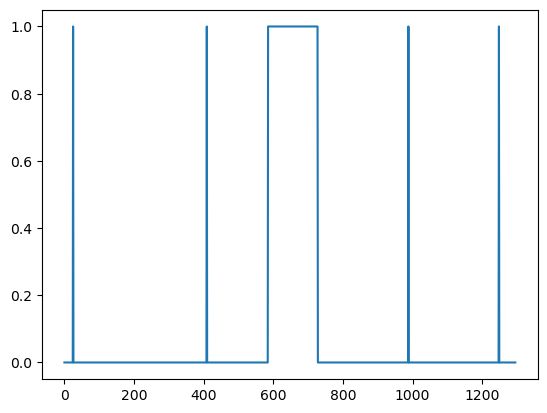

Chunk 1: 0/1107 labels with value 1


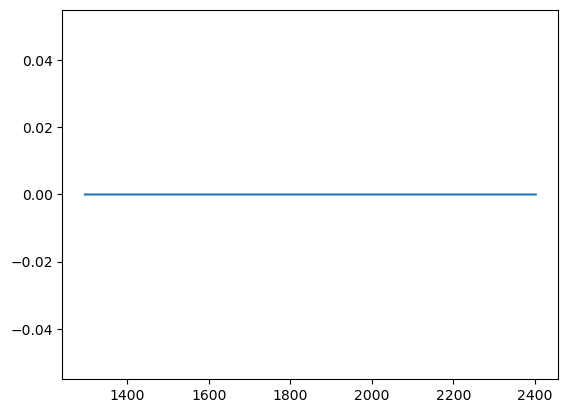

Chunk 2: 29/1098 labels with value 1


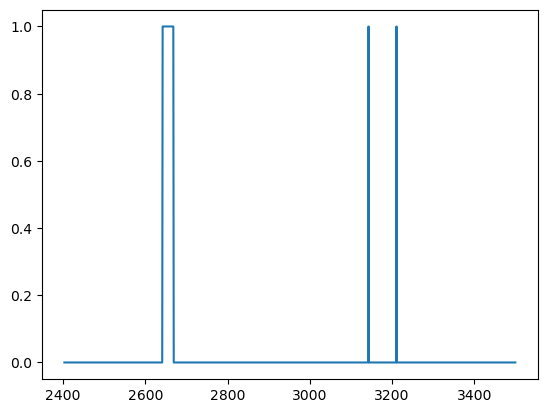

Chunk 3: 27/918 labels with value 1


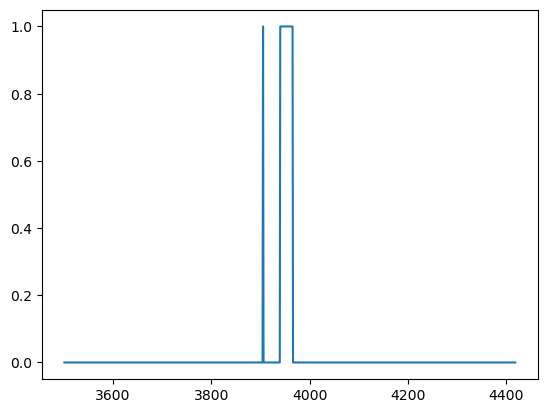

Chunk 4: 21/918 labels with value 1


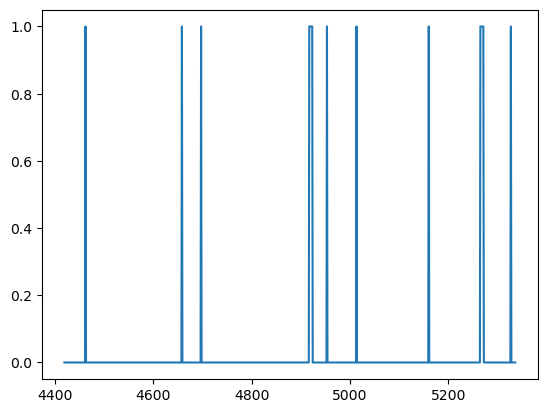

Chunk 5: 32/746 labels with value 1


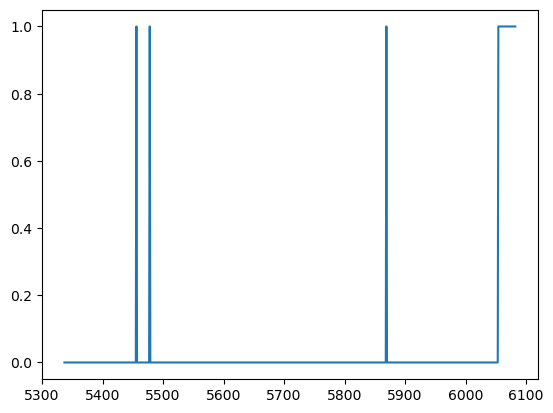

Chunk 6: 111/748 labels with value 1


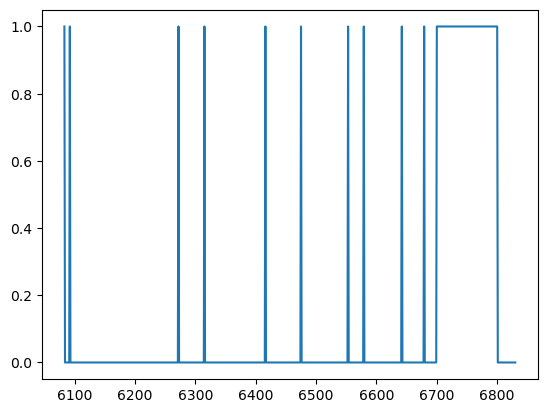

Chunk 7: 4/558 labels with value 1


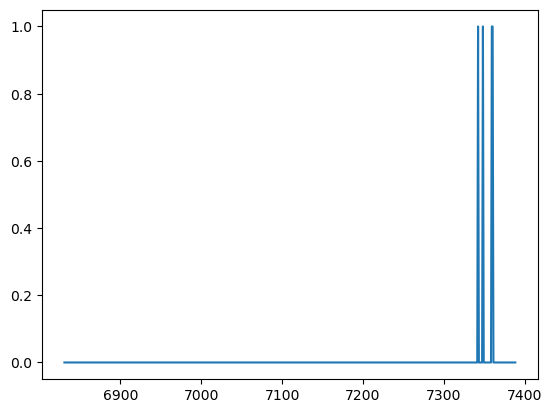

In [14]:
def plot_label_counts(predictions, chunk_sizes):
    for i, (start, end) in enumerate(chunk_sizes):
        chunk = predictions[start:end]
        num_labels = len(chunk[chunk['label'] == 1])
        print(f"Chunk {i}: {num_labels}/{len(chunk)} labels with value 1")
        plt.plot(chunk['label'])
        plt.show()
ranges = [(0, 1296), (1296, 2403), (2403, 3501), (3501, 4419), (4419, 5337), (5337, 6083), (6083, 6831), (6831, len(anomaly))]
plot_label_counts(submission, ranges)